In [1]:
from utils_tools.utils_extension_vis_2d import estimate_true_error_local_max, plot_2D_comparison_with_coverage_error_compare, visualize_selected_points, plot_metrics_table

In [2]:
import torch
import matplotlib.pyplot as plt

def visualize_selected_points(
    X: torch.Tensor,
    idx: torch.Tensor,
    *,
    domain: tuple[float, float] = (-1.0, 1.0),
    figsize=(6,6),
    selected_color="red",
    background_color="lightgray",
    marker_size=30,
    title: str | None = "Selected points"
):
    """
    Visualize selected points (idx) on 2D domain [-1,1]^2.

    Parameters
    ----------
    X : torch.Tensor
        (N, 2) full set of points in domain.
    idx : torch.Tensor
        1D LongTensor of selected indices.
    domain : tuple, default (-1,1)
        Plot limits for both x and y.
    figsize : tuple
        Matplotlib figure size.
    selected_color : str
        Color for selected points.
    background_color : str
        Color for non-selected points.
    marker_size : int
        Scatter marker size.
    title : str or None
        Plot title.
    """
    X = X.detach().cpu()
    idx = idx.detach().cpu()

    mask = torch.zeros(X.shape[0], dtype=bool)
    mask[idx] = True

    plt.figure(figsize=figsize)
    plt.scatter(X[~mask,0], X[~mask,1], c=background_color, s=marker_size, alpha=0.5, label="Unselected")
    plt.scatter(X[mask,0], X[mask,1], c=selected_color, s=marker_size, label="Selected")

    plt.xlim(domain)
    plt.ylim(domain)
    plt.gca().set_aspect("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    if title:
        plt.title(title)
    plt.legend()
    plt.show()


In [3]:
import torch
from typing import Sequence, Literal, Dict, Tuple, Optional
import math

def add_gaussian_noise_xy(  # now uses a single 'O' (ellipse ring) instead of 'C'+'P'
    xy: torch.Tensor,                 # (N, 2)
    u: torch.Tensor,                  # (N, 1) or (N,)
    *,
    centers: Sequence[Sequence[float]],  # kept for signature compatibility (unused)
    radii: float | Sequence[float] | Sequence[Sequence[float]],  # unused
    sigmas: float | Sequence[float],  # amplitude inside pattern (scalar or first elem)
    base_sigma: float = 0.0,          # background noise std
    index_eps: float = 1e-6,          # used only when index_mode="sigma"
    generator: torch.Generator | None = None,
    clamp: tuple[float, float] | None = None,
    return_sigma: bool = False,
    combine: Literal["sum", "max", "quadrature"] = "sum",
    edge_tau: float = 0.07,           # ABSOLUTE smoothing width for edges (for sigma only)

    # legacy CP layout knobs (ignored for 'O', kept for compatibility)
    letter_gap: Optional[float] = None,
    letter_stroke: Optional[float] = None,
    letters: Optional[Dict[str, object]] = None,

    # legacy C-shape knobs (ignored)
    c_open_frac: Optional[float] = None,
    c_gap_angle: Optional[float] = None,
    c_rx: Optional[float] = None,
    c_ry: Optional[float] = None,
    c_curl: Optional[float] = None,
    c_curl_width: Optional[float] = None,
    c_n: Optional[int] = None,
    c_to_p_width_ratio: Optional[float] = None,
    c_stretch_x: Optional[float] = None,

    # indexing controls
    index_mode: Literal["strict", "sigma"] = "strict",
    index_region: Literal["union", "intersection", "C", "P", "O"] = "O",  # default to 'O'
    index_margin: Optional[float] = -0.1,
):
    """
    Adds Gaussian noise with amplitude elevated only within an 'O' shape
    (an elliptical ring built as a polyline convolved with a circular capsule of radius stroke/2).

    Sigma weighting:
        w(x) = sigmoid( -sdf_O(x) / edge_tau )

    Indexing:
      - index_mode="strict": pick eroded interior of the ring via SDF:
            margin = index_margin if set else edge_tau
            idx = { i : sdf_O[i] <= -margin }
      - index_mode="sigma": legacy behavior using sigma threshold:
            idx = { i : (sigma[i] - base_sigma) > index_eps }

    Customize via `letters={"origin": (ox,oy), "size": (W,H), "stroke": s, "O": {"rx":..., "ry":..., "n":...}}`.
    Defaults: origin=(0.10,0.10), size=(0.80,0.80), stroke=0.12*min(W,H), rx=0.45, ry=0.45, n=192.
    """
    # -- basic checks --
    if xy.ndim != 2 or xy.shape[1] != 2:
        raise ValueError("xy must have shape (N, 2)")
    u = u.reshape(-1, 1)
    if xy.shape[0] != u.shape[0]:
        raise ValueError("xy and u must have the same number of points (N)")

    device, dtype = u.device, u.dtype
    XY = xy.to(device=device, dtype=dtype)

    # --- SDF helpers ---
    def _sdf_capsule(xy_: torch.Tensor, A: Tuple[float, float], B: Tuple[float, float], r: float) -> torch.Tensor:
        A = torch.tensor(A, device=device, dtype=dtype)
        B = torch.tensor(B, device=device, dtype=dtype)
        pa = xy_ - A
        ba = B - A
        denom = (ba * ba).sum()
        if float(denom) < torch.finfo(dtype).eps:
            return torch.linalg.norm(pa, dim=1) - r
        h = (pa[:, 0] * ba[0] + pa[:, 1] * ba[1]) / denom
        h = h.clamp(0.0, 1.0)
        qx = pa[:, 0] - h * ba[0]
        qy = pa[:, 1] - h * ba[1]
        return torch.sqrt(qx * qx + qy * qy) - r

    def _sdf_poly_capsule_union(xy_: torch.Tensor, pts: Sequence[Tuple[float, float]], r: float) -> torch.Tensor:
        pts = [tuple(map(float, p)) for p in pts]
        if len(pts) < 2:
            return torch.linalg.norm(xy_ - torch.tensor(pts[0], device=device, dtype=dtype), dim=1) - r
        sdf = torch.full((xy_.shape[0],), float('inf'), device=device, dtype=dtype)
        Ax, Ay = pts[0]
        for (Bx, By) in pts[1:]:
            sdf = torch.minimum(sdf, _sdf_capsule(xy_, (Ax, Ay), (Bx, By), r))
            Ax, Ay = Bx, By
        return sdf

    def _transform_pts(pts, origin: Tuple[float, float], size: Tuple[float, float]):
        ox, oy = origin; sx, sy = size
        t = torch.tensor(pts, device=device, dtype=dtype)
        t[:, 0] = ox + sx * t[:, 0]
        t[:, 1] = oy + sy * t[:, 1]
        return t

    # --- config ---
    cfg = letters or {}
    ox, oy = tuple(cfg.get("origin", (0.10, 0.10)))
    W_block, H_block = tuple(cfg.get("size", (0.80, 0.80)))
    tau_abs = max(float(edge_tau), 1e-12)

    # amplitude inside the O
    if cfg.get("sigma", None) is not None:
        S_val = float(cfg["sigma"])
    else:
        S_val = float(sigmas) if isinstance(sigmas, (int, float)) \
                else float(torch.as_tensor(sigmas, dtype=dtype).reshape(-1)[0].item())

    # stroke (ring thickness)
    if letter_stroke is not None:
        stroke_O = float(letter_stroke)
    elif "stroke" in cfg:
        stroke_O = float(cfg["stroke"])
    else:
        stroke_O = 0.12 * float(min(W_block, H_block))

    # --- O geometry (axis-aligned ellipse center-filled as a RING) ---
    O_cfg = cfg.get("O", {}) if isinstance(cfg.get("O", {}), dict) else {}
    rx = float(O_cfg.get("rx", 0.45))
    ry = float(O_cfg.get("ry", 0.45))
    nO = int(O_cfg.get("n", 192))  # polyline density

    def _canonical_O_polyline(n: int):
        # points on an ellipse centered at (0.5, 0.5) with radii rx, ry, closed loop
        thetas = torch.linspace(0.0, 2.0 * torch.pi, steps=n, device=device, dtype=dtype)
        cx, cy = 0.5, 0.5
        xs = cx + rx * torch.cos(thetas)
        ys = cy + ry * torch.sin(thetas)
        pts = list(zip(xs.tolist(), ys.tolist()))
        # close the loop explicitly to ensure last segment connects to first
        pts.append(pts[0])
        return pts

    origin_O = (ox, oy)
    size_O   = (W_block, H_block)

    # SDF for the ring (capsule union around the ellipse polyline)
    poly_O = _transform_pts(_canonical_O_polyline(nO), origin_O, size_O).tolist()
    sdf_O = _sdf_poly_capsule_union(XY, poly_O, r=float(stroke_O) * 0.5)  # (N,)

    # Smoothed weight for sigma
    wO = torch.sigmoid(-sdf_O / tau_abs).to(dtype).unsqueeze(1)

    # Build sigma field
    if combine == "sum":
        sigma = base_sigma + S_val * wO
    elif combine == "max":
        sigma = base_sigma + S_val * wO
    elif combine == "quadrature":
        sigma = (base_sigma**2 + (S_val * wO)**2).sqrt()
    else:
        raise ValueError("combine must be 'sum', 'max', or 'quadrature'")
    sigma = sigma.clamp_min(0)

    # ======================== IDX CONTROL =========================
    if index_mode == "sigma":
        idx = torch.nonzero((sigma.view(-1) - float(base_sigma)) > float(index_eps),
                            as_tuple=False).squeeze(1)
    else:
        # STRICT interior of the ring; any legacy value maps to 'O'
        margin = float(index_margin) if index_margin is not None else float(tau_abs)
        sdf_sel = sdf_O  # only 'O' exists
        mask = sdf_sel <= (-margin)          # eroded interior (ring core)
        idx = torch.nonzero(mask, as_tuple=False).squeeze(1)
    # ====================== END IDX CONTROL ======================

    # Sample and add noise
    noise = torch.normal(mean=torch.zeros_like(u), std=sigma, generator=generator)
    u_noisy = u + noise
    if clamp is not None:
        lo, hi = clamp
        u_noisy = u_noisy.clamp(min=lo, max=hi)

    return (u_noisy, sigma, idx) if return_sigma else (u_noisy, idx)


In [4]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn
# Basic
import torch
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
from numpy import random
# torch.set_num_threads(4)

# PDEi
from utils_pde.utils_pde_2dpoisson import Poisson2D

# Viz
from utils_tools.utils_result_viz import plot_predictions_2D
from utils_tools.utils_tuning import save_plot

# Base Mdoels
from utils_uqmd.utils_uq_dropout import DropoutPINN
from utils_uqmd.utils_uq_mlp import MLPPINN
from utils_uqmd.utils_uq_vi import VIBPINN
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# CP
from utils_uqmd.utils_uq_cp import CP

torch.set_num_threads(4)
# 7
seed = 711
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_allencahn2d import AllenCahn2D

# 1) keep the torch-based definition
def true_solution(xy):
    return torch.sin(math.pi*xy[...,0:1]) * torch.sin(math.pi*xy[...,1:2])

domain=((-1.0, 1.0), (-1.0, 1.0))
pde = AllenCahn2D(lam=0.05, domain=domain, true_solution=true_solution)

# ────────────────────────────────────────────────────────────────────────────────
# 2. Data Generation (Noisy data for training, test, calibration)
# ────────────────────────────────────────────────────────────────────────────────
colloc_pt_num = 1024  # Number of collocation points

data_noise = 0.05
N_train = 300
N_test = 2000 # 2000
N_calib = 100


N_total= N_train+N_test+N_calib

X_train, Y_train = pde.data_generation(N_train, data_noise)
X_test, Y_test = pde.data_generation(N_test, data_noise)
X_calibration, Y_calibration = pde.data_generation(N_calib, data_noise)


# Not involved in numerical experiment
N_valid = 200
X_validation, Y_validation= pde.data_generation(N_valid, data_noise)
X_vis, Y_vis = pde.data_generation(N_total, data_noise)
# Generating alphas to test
from utils_tools.utils_result_metrics import generating_alphas
alphas = generating_alphas(n=20, step=0.05)

alpha = 0.05

# ────────────────────────────────────────────────────────────────────────────────
# 3. Visualization: Plot ground-truth & noisy data
# ────────────────────────────────────────────────────────────────────────────────

def make_dense_grid(domain, N=200):
    x = np.linspace(domain[0][0], domain[0][1], N)
    y = np.linspace(domain[1][0], domain[1][1], N)
    X, Y = np.meshgrid(x, y)
    XY_grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    return XY_grid, X, Y

import matplotlib.pyplot as plt

def plot_truth_and_samples_2D(
    X_train, Y_train, grid, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
):
    fig, ax = plt.subplots(figsize=(7, 6))
    # Show the true solution as a colormap
    x = np.linspace(domain[0][0], domain[0][1], U_true_grid.shape[0])
    y = np.linspace(domain[1][0], domain[1][1], U_true_grid.shape[1])
    im = ax.imshow(
        U_true_grid,
        extent=(domain[0][0], domain[0][1], domain[1][0], domain[1][1]),
        origin='lower',
        aspect='auto',
        alpha=0.8,
        cmap='coolwarm'
    )
    # Overlay noisy training points
    ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, edgecolor='k', cmap='viridis', s=18, label="Noisy samples")
    plt.colorbar(im, ax=ax, label="u(x, y)")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()



# 4) plot again
grid_test, X_mesh, Y_mesh = make_dense_grid(domain, 500)
grid_test_torch = torch.tensor(grid_test, dtype=torch.float32)
U_true_grid = true_solution(grid_test_torch).numpy().reshape(X_mesh.shape)


# --------------------------------------------
# Defining Testing
# --------------------------------------------
n_grid = 500
g  = torch.Generator().manual_seed(seed)

letters = {
    "origin": (-0.3, -0.3),
    "size": (1.0, 1.0),
    "stroke": 0.1,           # ring thickness (absolute units)
    # "sigma": 0.7,           # optional: amplitude inside the ring; overrides sigmas=...
    "O": {"rx": 0.6, "ry": 0.5, "n": 256}
}

# Define printing grid
grid_test, u = pde.solution_field_on_grid(n_grid, source="true", flatten=True)
u_noisy, sigma, id_grid = add_gaussian_noise_xy(
    grid_test, u,
    centers=[], radii=0.0, sigmas=0.5,  # omit these if you applied fix #2
    letters=letters,
    return_sigma=True,
    base_sigma = 0.05
)

Y_train_clean = Y_train.clone()
Y_test_clean  = Y_test.clone()
Y_cal_clean   = Y_calibration.clone()

Y_train, sigma_train, id_train = add_gaussian_noise_xy(
    X_train, Y_train_clean,
    centers=[], radii=0.0, sigmas=0.5,  # omit these if you applied fix #2
    letters=letters,
    return_sigma=True
)

Y_calibration, sigma_calibration, id_calibration = add_gaussian_noise_xy(
    X_calibration, Y_cal_clean,
    centers=[], radii=0.0, sigmas=0.5,  # omit these if you applied fix #2
    letters=letters,
    return_sigma=True
)


save_plot(
    plot_truth_and_samples_2D,
    save_dir="2D_AllenCahn", prefix="2D_AllenCahn_data",
)(
    X_test, Y_test, grid_test, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
)

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Using device: cpu


<Figure size 640x480 with 0 Axes>

In [5]:
err_est_noise = estimate_true_error_local_max(grid_test, u_noisy, nghd_size=40)

# Feature Distance model

In [6]:
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# Base-Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":2,
    "hidden_dims":[16, 32, 64, 64, 64, 32, 16], 
    "output_dim":1,
}
raw_heuristic = "feature"
# CP-Model
k=30 #30
cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k
}

baseline_testing_args = { 
    # "uqmodel":dist_pinn
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "heuristic_u":raw_heuristic,
    "n_samples":k
}

dist_feat_pinn = DistanceUQPINN(**model_args)

In [7]:
# Base Model
# Training
fit_args = dict(
    coloc_pt_num=colloc_pt_num, 
    X_train=X_train, 
    Y_train=Y_train
)
fit_kwargs_grid = dict(
    epochs=4500,
    λ_pde=1.0, λ_ic=5.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
baseline_loss_dict = dist_feat_pinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = dist_feat_pinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=k,
    heuristic_u="feature"
)
dist_feat_pinn_uncal_predset = dist_feat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     1 | L=2.11e+02 | lr=1.0e-03
ep   500 | L=9.57e-02 | lr=1.0e-03
ep  1000 | L=3.69e-02 | lr=1.0e-03
ep  1500 | L=2.57e-02 | lr=1.0e-03
ep  2000 | L=2.21e-02 | lr=1.0e-03
ep  2500 | L=2.02e-02 | lr=1.0e-03
ep  3000 | L=1.91e-02 | lr=1.0e-03
ep  3500 | L=1.83e-02 | lr=1.0e-03
ep  4000 | L=1.79e-02 | lr=1.0e-03
ep  4500 | L=1.75e-02 | lr=1.0e-03


In [8]:
dist_feat_pinn_uncal_predset = dist_feat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)

# CP

In [9]:
# CP Model
dist_feat_pinn_cp = CP(dist_feat_pinn)

# Predicting
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"feature",  # Change this based on cp
        "k":k
}

dist_feat_pinn_cp_cal_predset = dist_feat_pinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

# Local CP

In [10]:
# CP Model (Adaptive)
from utils_extension.utils_uq_adapcp import AdaptiveCP_f, adaptive_cp_test_uncertainties_grid
training_kwargs={"step_size":5000, "gamma":0.5}
quantile_net_config = {
    "conf_nn_hidden_layers":(16, 32, 64, 64, 128, 64, 64, 32, 16),
    "conf_nn_lr":9e-5,
    "conf_nn_epochs":20000,
    "training_kwargs":training_kwargs,
    "quant_seed":seed
}
adap_kwarg={
    "alpha":alpha,
    "heuristic":raw_heuristic,
    **quantile_net_config
}

adap_cp = AdaptiveCP_f(dist_feat_pinn, **adap_kwarg)
adp_cp_cal_predset = adap_cp.predict(
    alpha=alpha, X_test=grid_test, X_train=X_train, Y_train=Y_train,
    X_cal=X_calibration, Y_cal=Y_calibration, k=k
)


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


# Plot the results

(<Figure size 2200x500 with 5 Axes>,
 array([<Axes: xlabel='x', ylabel='y'>, <Axes: xlabel='x'>,
        <Axes: xlabel='x'>, <Axes: xlabel='x'>], dtype=object))

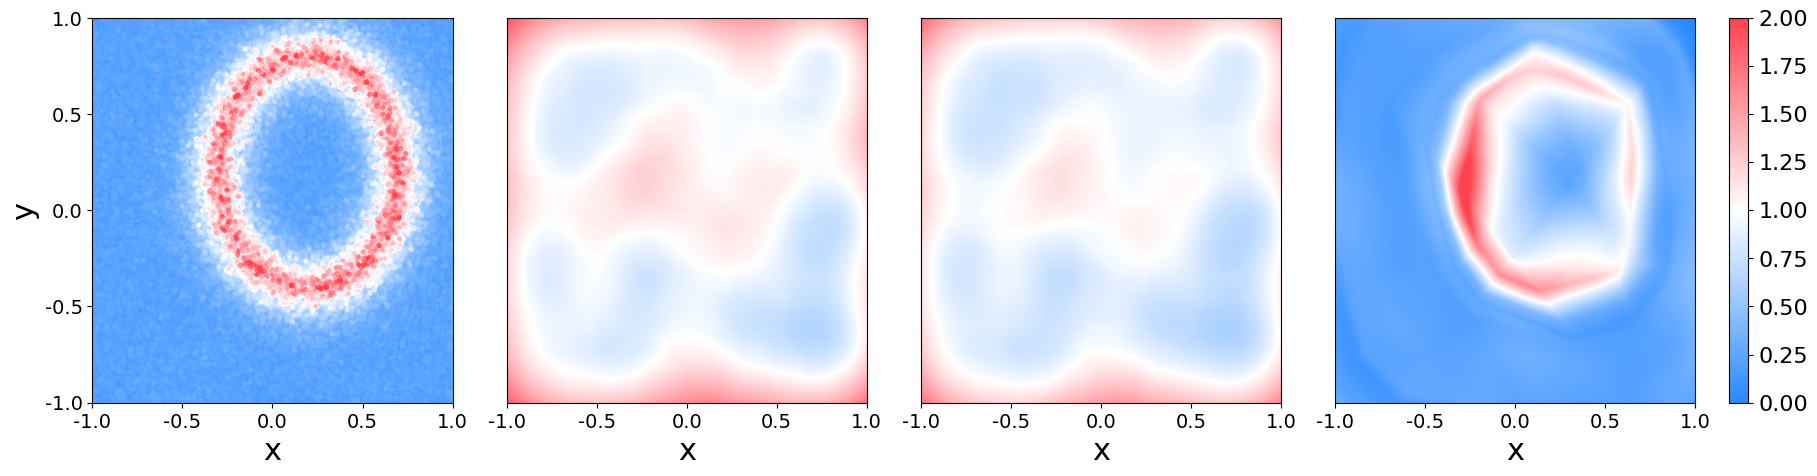

In [11]:
plot_2D_comparison_with_coverage_error_compare(
    grid_test,
    err_est_noise, # 2*(sigma*1.69),
    dist_feat_pinn_uncal_predset,
    dist_feat_pinn_cp_cal_predset,
    adp_cp_cal_predset, #<--
    true_solution, 
    vlim=(0,2.0),
    # noisy_mask=id_grid, 
    x_tick_step=0.5, y_tick_step=0.5,      # major ticks every 0.1
    grid_size=500
)

In [12]:
save_plot(
    plot_2D_comparison_with_coverage_error_compare,
    save_dir="Local_CP_2D",
    prefix="2lett"
)(
    grid_test,
    err_est_noise, # 2*(sigma*1.69),
    dist_feat_pinn_uncal_predset,
    dist_feat_pinn_cp_cal_predset,
    adp_cp_cal_predset, #<--
    true_solution, 
    vlim=(0,2.0),
    # noisy_mask=id_grid, 
    x_tick_step=0.5, y_tick_step=0.5,      # major ticks every 0.1
    grid_size=500
)

<Figure size 640x480 with 0 Axes>

# Test across the alpha grid

In [13]:
Y_test, sigma_test, id_test = add_gaussian_noise_xy(
    X_test, Y_test_clean,
    centers=[], radii=0.0, sigmas=0.5,  # omit these if you applied fix #2
    letters=letters,
    return_sigma=True,
    index_margin=0.0
)

In [14]:
# CP Coverage comparison
from utils_extension.utils_uq_adapcp import adaptive_cp_test_uncertainties_grid_2d_ac, cp_test_uncertainties_in_noisy_region
# Conformal-prediction settings
from utils_tools.utils_result_metrics import generating_alphas




cp_testing_args = {
    "uqmodel": dist_feat_pinn_cp,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "idx_noisy_test":id_test,
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k
}
adapcp_testing_args = {
    "base_md": dist_feat_pinn,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "idx_noisy_test":id_test,
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k,
    **quantile_net_config
}
cp_df_local = cp_test_uncertainties_in_noisy_region(**cp_testing_args)
adap_df_local = adaptive_cp_test_uncertainties_grid_2d_ac(**adapcp_testing_args)

Adaptive-CP grid:   0%|          | 0/19 [00:00<?, ?it/s]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:   5%|▌         | 1/19 [00:34<10:15, 34.20s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  11%|█         | 2/19 [01:07<09:30, 33.58s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  16%|█▌        | 3/19 [01:38<08:42, 32.67s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  21%|██        | 4/19 [02:11<08:07, 32.47s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  26%|██▋       | 5/19 [02:43<07:34, 32.48s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  32%|███▏      | 6/19 [03:15<06:58, 32.22s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  37%|███▋      | 7/19 [03:47<06:25, 32.09s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  42%|████▏     | 8/19 [04:18<05:51, 31.96s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  47%|████▋     | 9/19 [04:51<05:21, 32.15s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  53%|█████▎    | 10/19 [05:23<04:49, 32.22s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  58%|█████▊    | 11/19 [05:56<04:18, 32.26s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  63%|██████▎   | 12/19 [06:28<03:46, 32.41s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  68%|██████▊   | 13/19 [07:01<03:14, 32.46s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  74%|███████▎  | 14/19 [07:35<02:44, 32.80s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  79%|███████▉  | 15/19 [08:09<02:13, 33.31s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  84%|████████▍ | 16/19 [08:43<01:40, 33.54s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  89%|████████▉ | 17/19 [09:16<01:06, 33.34s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  95%|█████████▍| 18/19 [09:48<00:33, 33.04s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid: 100%|██████████| 19/19 [10:20<00:00, 32.65s/it]


In [15]:

import torch
from typing import Sequence, Literal
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics_table(
    X_test: torch.Tensor,
    cp_uncal_predset,
    cp_cal_predset,
    true_solution,
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    df1_name: str="Uncalibrated",
    df2_name: str="Calibrated",
    title: str = "",
    main_title: str | None = None,
    X_vis=None, Y_vis=None,
    alpha_level: float = 0.05,
    figsize: tuple = (9, 2.5),
    max_digits_display = lambda x: f"{x:.4g}"
):
    """
    Display a side-by-side metrics comparison (table) for the uncalibrated and
    calibrated models at a single alpha level.
    """
    # Compute the coverage deviation using mae
    def prepare_coverage_data(df):
        expected = 1 - df["alpha"]
        empirical = df["coverage"]
        exp_full = pd.concat([pd.Series([0.0]), expected, pd.Series([1.0])], ignore_index=True)
        emp_full = pd.concat([pd.Series([0.0]), empirical, pd.Series([1.0])], ignore_index=True)
        sort_idx = exp_full.argsort()
        exp_sorted, emp_sorted = exp_full[sort_idx], emp_full[sort_idx]
        return exp_sorted.to_numpy(), emp_sorted.to_numpy()

    def coverage_deviation(exp, emp, how="mae"):
        diff = np.abs(emp - exp)
        if   how == "mae":  return diff.mean()
        elif how == "rmse": return np.sqrt((diff**2).mean())
        elif how == "max":  return diff.max()
        else:
            raise ValueError("metric must be 'mae', 'rmse', or 'max'")

    exp1, emp1 = prepare_coverage_data(df1)
    exp2, emp2 = prepare_coverage_data(df2)
    dev1 = coverage_deviation(exp1, emp1)  # Using the default metrics
    dev2 = coverage_deviation(exp2, emp2)  # Using the default metrics
    print(f"Uncal dev:{dev1}")
    print(f"Cal dev:{dev2}")
    alpha_level_upper = alpha_level + 1e-3
    alpha_level_lower = alpha_level - 1e-3
    
    # ────────────────────── 1. Slice the two rows ──────────────────────
    row_uncal = df1.loc[(df1["alpha"] <= alpha_level_upper) & 
                           (df1["alpha"] >= alpha_level_lower)].copy()
    row_uncal["model"] = df1_name
    row_uncal["expected coverage"] = (1 - row_uncal["alpha"])
    row_uncal["mean coverage deviation"] = "{:.4f}".format(dev1)
    row_uncal["coverage"] = (row_uncal["coverage"]).map("{:.2f}".format)

    row_cal = df2.loc[(df2["alpha"] <= alpha_level_upper) & 
                        (df2["alpha"] >= alpha_level_lower)].copy()
    row_cal["model"] = df2_name
    row_cal["expected coverage"] = (1- row_cal["alpha"])
    row_cal["mean coverage deviation"] = "{:.4f}".format(dev2)
    row_cal["coverage"] = (row_cal["coverage"]).map("{:.2f}".format)

    if row_uncal.empty or row_cal.empty:
        raise ValueError(f"alpha={alpha_level} not found in both data frames.")

    # ───────────────────── 2. Stack & tidy up ──────────────────────────
    rows = pd.concat([row_uncal, row_cal], axis=0).reset_index(drop=True)
    rows = rows.rename(columns={"coverage": "actual coverage"})
    # Get all columns except 'model' for the selection
    other_cols = [c for c in rows.columns if c != "model"]
    rows = rows.loc[:, ["model"] + other_cols]

    
    # nice ordering: model | expected alpha | true alpha | <metrics…>
    metric_cols = [c for c in rows.columns if c not in ("model", "expected coverage", "actual coverage", "mean coverage deviation", "sharpness")]
    rows = rows[["model", "expected coverage", "actual coverage", "mean coverage deviation", "sharpness"]]
    

    # ──────────────── 2.5. Format numeric values ───────────────────────
    # Format all numeric columns to 4 decimal places (excluding 'model' column)
    for col in rows.columns:
        if pd.api.types.is_numeric_dtype(rows[col]):
            rows[col] = rows[col].apply(max_digits_display)  # .4g gives up to 4 significant 

    # ───────────────────── 3. Plot as table ────────────────────────────
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("off")

    table = ax.table(
        cellText=rows.values,
        colLabels=rows.columns,
        loc="center",
        cellLoc="center",
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.25)

    if main_title is not None:
        plt.title(main_title, pad=20, fontsize=12)

    plt.tight_layout()


Uncal dev:0.2619047666057235
Cal dev:0.04855389041560037


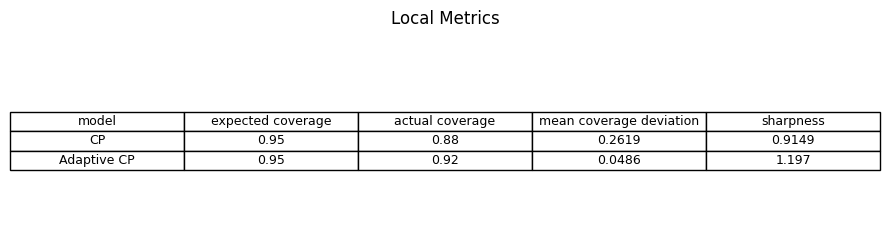

In [16]:
plot_metrics_table(None,None,None,None,cp_df_local,adap_df_local,"CP" ,"Adaptive CP", alpha_level=0.05, 
  main_title="Local Metrics"
)


In [17]:
# Global Metrics

# CP Coverage comparison
from utils_extension.utils_uq_adapcp import adaptive_cp_test_uncertainties_grid, cp_test_uncertainties_in_noisy_region
from utils_tools.utils_result_metrics import cp_test_uncertainties
# Conformal-prediction settings
from utils_tools.utils_result_metrics import generating_alphas

cp_testing_args = {
    "uqmodel": dist_feat_pinn_cp,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k
}
adapcp_testing_args = {
    "base_md": dist_feat_pinn,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k,
    **quantile_net_config
}
cp_df_global = cp_test_uncertainties(**cp_testing_args)
adap_df_global = adaptive_cp_test_uncertainties_grid_2d_ac(**adapcp_testing_args)

Adaptive-CP grid:   0%|          | 0/19 [00:00<?, ?it/s]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:   5%|▌         | 1/19 [00:32<09:50, 32.83s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  11%|█         | 2/19 [01:05<09:13, 32.55s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  16%|█▌        | 3/19 [01:35<08:26, 31.65s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  21%|██        | 4/19 [02:06<07:48, 31.23s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  26%|██▋       | 5/19 [02:37<07:16, 31.16s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  32%|███▏      | 6/19 [03:08<06:43, 31.06s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  37%|███▋      | 7/19 [03:39<06:11, 30.97s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  42%|████▏     | 8/19 [04:09<05:40, 30.92s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  47%|████▋     | 9/19 [04:40<05:08, 30.88s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  53%|█████▎    | 10/19 [05:11<04:37, 30.88s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  58%|█████▊    | 11/19 [05:41<04:06, 30.75s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  63%|██████▎   | 12/19 [06:12<03:34, 30.65s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  68%|██████▊   | 13/19 [06:42<03:03, 30.57s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  74%|███████▎  | 14/19 [07:13<02:32, 30.53s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  79%|███████▉  | 15/19 [07:43<02:02, 30.52s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  84%|████████▍ | 16/19 [08:14<01:31, 30.55s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  89%|████████▉ | 17/19 [08:44<01:01, 30.51s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  95%|█████████▍| 18/19 [09:15<00:30, 30.44s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid: 100%|██████████| 19/19 [09:45<00:00, 30.80s/it]


Uncal dev:0.033428575488783065
Cal dev:0.027928573389848072


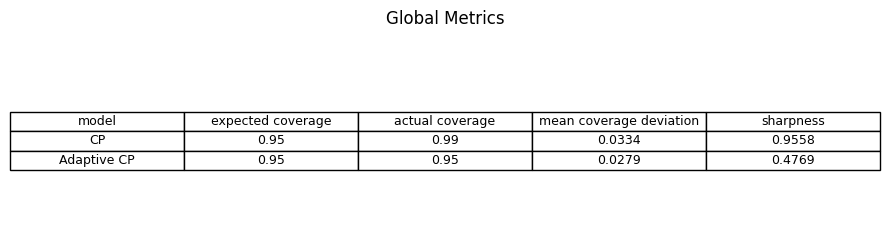

In [18]:
df1=cp_df_global
df2=adap_df_global
df1_name="CP" 
df2_name="Adaptive CP"

plot_metrics_table(None,None,None,None,df1,df2,df1_name,df2_name, alpha_level=0.05, 
  main_title="Global Metrics"
)

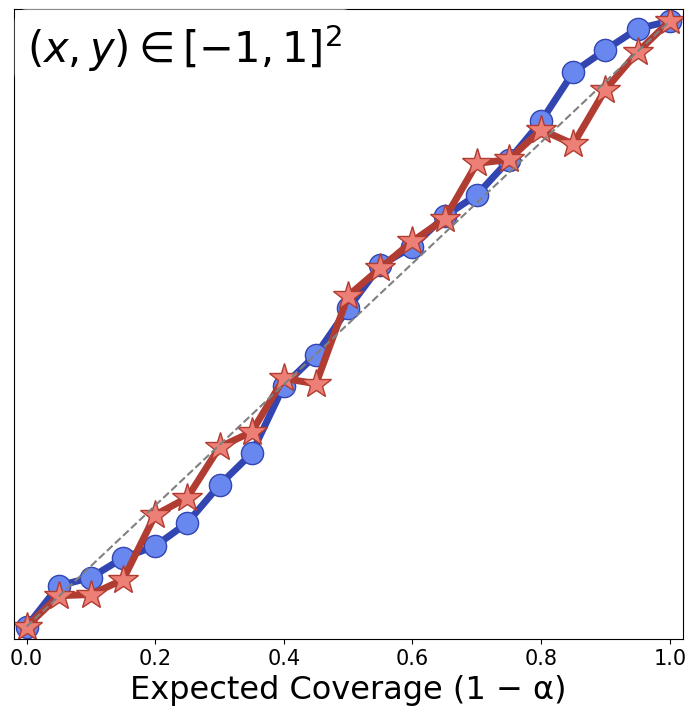

<Figure size 640x480 with 0 Axes>

In [19]:
def plot_coverage_single(
    name_dfpair,
    *,
    labels=("CP", "Local CP"),
    figsize=(7, 7.5),
    suptitle=None,
    model_title_size=28,
    float_label="$x \in \{x:c=(0,0), r=0.2\}$",
):
    """
    Plot a single coverage curve plot (no subplots).

    Parameters
    ----------
    name_dfpair : tuple
        (name, df_uncal, df_cal), where each df has 'alpha' and 'coverage' columns.
    labels : tuple(str, str)
        Legend labels for the two curves (uncal vs cal).
    figsize : tuple
        Figure size.
    suptitle : str | None
        Optional overall figure title.
    model_title_size : int
        Title fontsize for the subplot.
    float_label : tuple(str, str)
        Floating labels to place at top-left corner of the plot.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    def _prep(df):
        exp = 1.0 - df["alpha"].to_numpy()
        emp = df["coverage"].to_numpy()
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        i = np.argsort(exp)
        return exp[i], emp[i]

    name, df_uncal, df_cal = name_dfpair

    plt.figure(figsize=figsize)

    exp1, emp1 = _prep(df_uncal)
    exp2, emp2 = _prep(df_cal)

    plt.plot(exp1, emp1, 'o-', color="#3245b1", markerfacecolor="#6988ef",
                     ms=16, lw=5, label=labels[1])
    plt.plot(exp2, emp2, '*-', color="#b13c32", markerfacecolor="#ed8076",
                     ms=22, lw=5, label=labels[0])
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')

    # # floating label
    # if float_label[0]:
    #     plt.text(
    #         0.02, 0.98, float_label[0],
    #         transform=plt.gca().transAxes,
    #         fontsize=22, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    # if float_label[1]:
    #     plt.text(
    #         0.02, 0.90, float_label[1],
    #         transform=plt.gca().transAxes,
    #         fontsize=16, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    # plt.text(
    #         0.02, 0.98, "Global",
    #         transform=plt.gca().transAxes,
    #         fontsize=28, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    plt.text(
            0.02, 0.98, float_label,
            transform=plt.gca().transAxes,
            fontsize=30, fontweight="bold",
            va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
        )

    plt.xlabel("Expected Coverage (1 − α)", fontsize=23)
    # plt.ylabel("Empirical Coverage", fontsize=18)
    # plt.title(name, fontsize=model_title_size, fontweight="bold")
    plt.margins(x=0.02, y=0.02)
    plt.yticks([])
    # plt.xticks([])
    # plt.legend(loc="lower right", fontsize=14, frameon=True)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.tick_params(axis='both', labelsize=15)
    return plt


pairs = ("Scenario C", cp_df_global,    adap_df_global)


plot_coverage_single(
    pairs,
    float_label=r"$(x,y) \in [-1, 1]^2$"
)
plt.show()

save_plot(
    plot_coverage_single,
    save_dir="Local_CP_2D",
    prefix="cov_B_global"
)(
    pairs,
    float_label=r"$(x,y) \in [-1, 1]^2$"
)



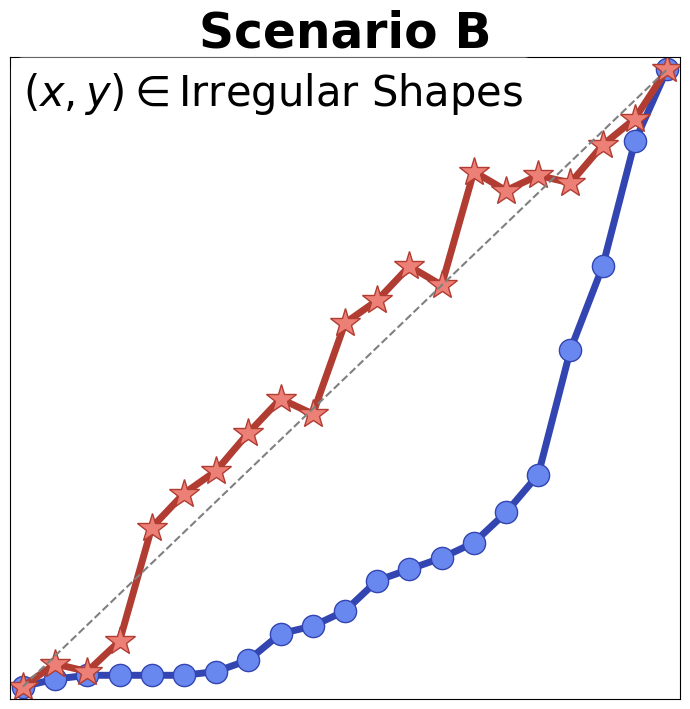

<Figure size 640x480 with 0 Axes>

In [20]:
def plot_coverage_single(
    name_dfpair,
    *,
    labels=("CP", "Local CP"),
    figsize=(7, 7.5),
    suptitle=None,
    model_title_size=35,
    float_label="$x \in \{x:c=(0,0), r=0.2\}$",
):
    """
    Plot a single coverage curve plot (no subplots).

    Parameters
    ----------
    name_dfpair : tuple
        (name, df_uncal, df_cal), where each df has 'alpha' and 'coverage' columns.
    labels : tuple(str, str)
        Legend labels for the two curves (uncal vs cal).
    figsize : tuple
        Figure size.
    suptitle : str | None
        Optional overall figure title.
    model_title_size : int
        Title fontsize for the subplot.
    float_label : tuple(str, str)
        Floating labels to place at top-left corner of the plot.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    def _prep(df):
        exp = 1.0 - df["alpha"].to_numpy()
        emp = df["coverage"].to_numpy()
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        i = np.argsort(exp)
        return exp[i], emp[i]

    name, df_uncal, df_cal = name_dfpair

    plt.figure(figsize=figsize)

    exp1, emp1 = _prep(df_uncal)
    exp2, emp2 = _prep(df_cal)

    plt.plot(exp1, emp1, 'o-', color="#3245b1", markerfacecolor="#6988ef",
                     ms=16, lw=5, label=labels[1])
    plt.plot(exp2, emp2, '*-', color="#b13c32", markerfacecolor="#ed8076",
                     ms=22, lw=5, label=labels[0])
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')

    # # floating label
    # if float_label[0]:
    #     plt.text(
    #         0.02, 0.98, float_label[0],
    #         transform=plt.gca().transAxes,
    #         fontsize=22, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    # if float_label[1]:
    #     plt.text(
    #         0.02, 0.90, float_label[1],
    #         transform=plt.gca().transAxes,
    #         fontsize=16, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    # plt.text(
    #         0.02, 0.98, "Local",
    #         transform=plt.gca().transAxes,
    #         fontsize=28, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    plt.text(
            0.02, 0.98, float_label,
            transform=plt.gca().transAxes,
            fontsize=30, fontweight="bold",
            va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
        )

    # plt.xlabel("Expected Coverage (1 − α)", fontsize=23)
    # plt.ylabel("Empirical Coverage", fontsize=18)
    plt.title(name, fontsize=model_title_size, fontweight="bold")
    plt.margins(x=0.02, y=0.02)
    plt.yticks([])
    plt.xticks([])
    # plt.legend(loc="lower right", fontsize=14, frameon=True)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.tick_params(axis='both', labelsize=15)
    return plt

pairs = ("Scenario B", cp_df_local,    adap_df_local)


plot_coverage_single(
    pairs,
    float_label=r"$(x,y) \in \mathrm{Irregular\ Shapes}$"
)

save_plot(
    plot_coverage_single,
    save_dir="Local_CP_2D",
    prefix="cov_B_local"
)(
    pairs,
    float_label=r"$(x,y) \in \mathrm{Irregular\ Shapes}$"
)

In [21]:
err_est_noise = estimate_true_error_local_max(grid_test, u_noisy, nghd_size=55)

(<Figure size 2200x500 with 5 Axes>,
 array([<Axes: xlabel='x', ylabel='y'>, <Axes: xlabel='x'>,
        <Axes: xlabel='x'>, <Axes: xlabel='x'>], dtype=object))

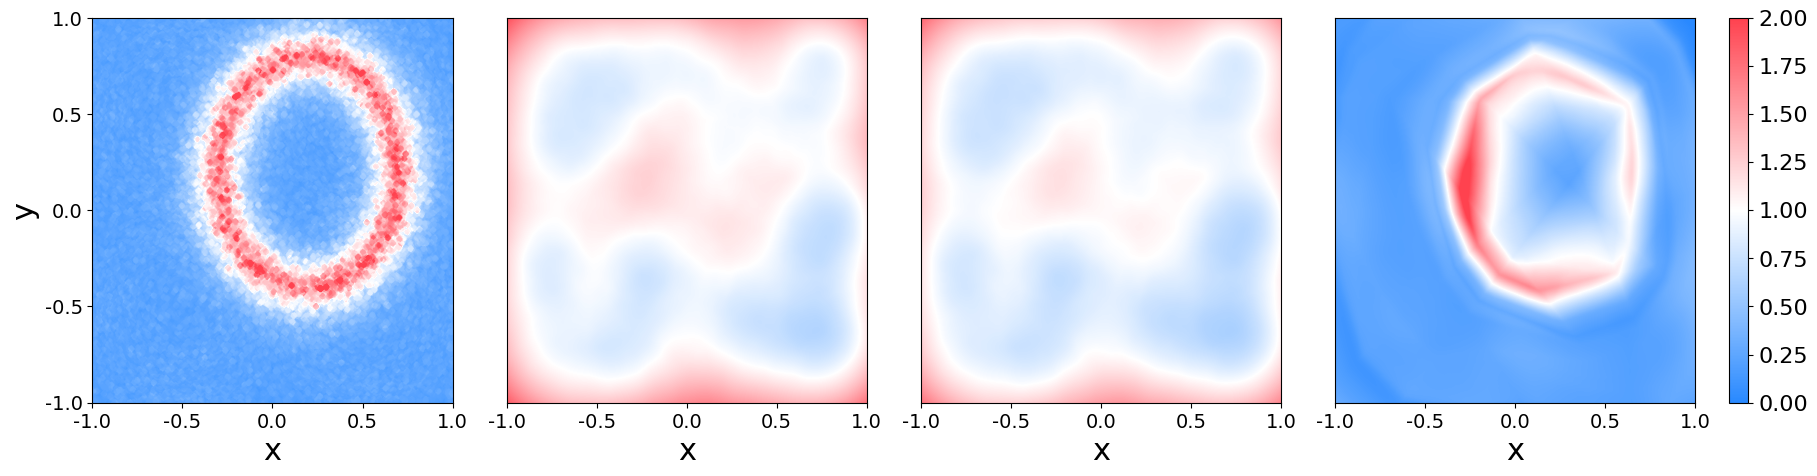

In [22]:

plot_2D_comparison_with_coverage_error_compare(
    grid_test,
    err_est_noise, # 2*(sigma*1.69),
    dist_feat_pinn_uncal_predset,
    dist_feat_pinn_cp_cal_predset,
    adp_cp_cal_predset, #<--
    true_solution, 
    vlim=(0,2.0),
    # noisy_mask=id_grid, 
    x_tick_step=0.5, y_tick_step=0.5,      # major ticks every 0.1
    grid_size=500
)

In [23]:
save_plot(
    plot_2D_comparison_with_coverage_error_compare,
    save_dir="Local_CP_2D",
    prefix="err_plot_O"
)(
    grid_test,
    err_est_noise, # 2*(sigma*1.69),
    dist_feat_pinn_uncal_predset,
    dist_feat_pinn_cp_cal_predset,
    adp_cp_cal_predset, #<--
    true_solution, 
    vlim=(0,2.0),
    # noisy_mask=id_grid, 
    x_tick_step=0.5, y_tick_step=0.5,      # major ticks every 0.1
    grid_size=500
)

<Figure size 640x480 with 0 Axes>